In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import h5py
from pykeops.torch import LazyTensor, generic_sum
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy.special import gamma, kv

import sys
sys.path.append("../..")
from losses import squared_error, relative_error
from rkhs_functions import RKHSFunction
from constraints import Symmetric, FlipSymmetric
from helper import trapezoid_rule, standard_deviation

from training_functions import train_rkhs_pde

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Poisson Study of Kernel Size vs. Weight Discretization

In [3]:
sweeps = np.load("poisson_sweep.npz")
interp_res = sweeps["interp_res"][:, :, :, 0, :]
G_res = sweeps["G_res"][:, :, :, 0]
beta_res = sweeps["beta_res"][:, :, :, 0]
1 - np.mean(np.isnan(interp_res))

1.0

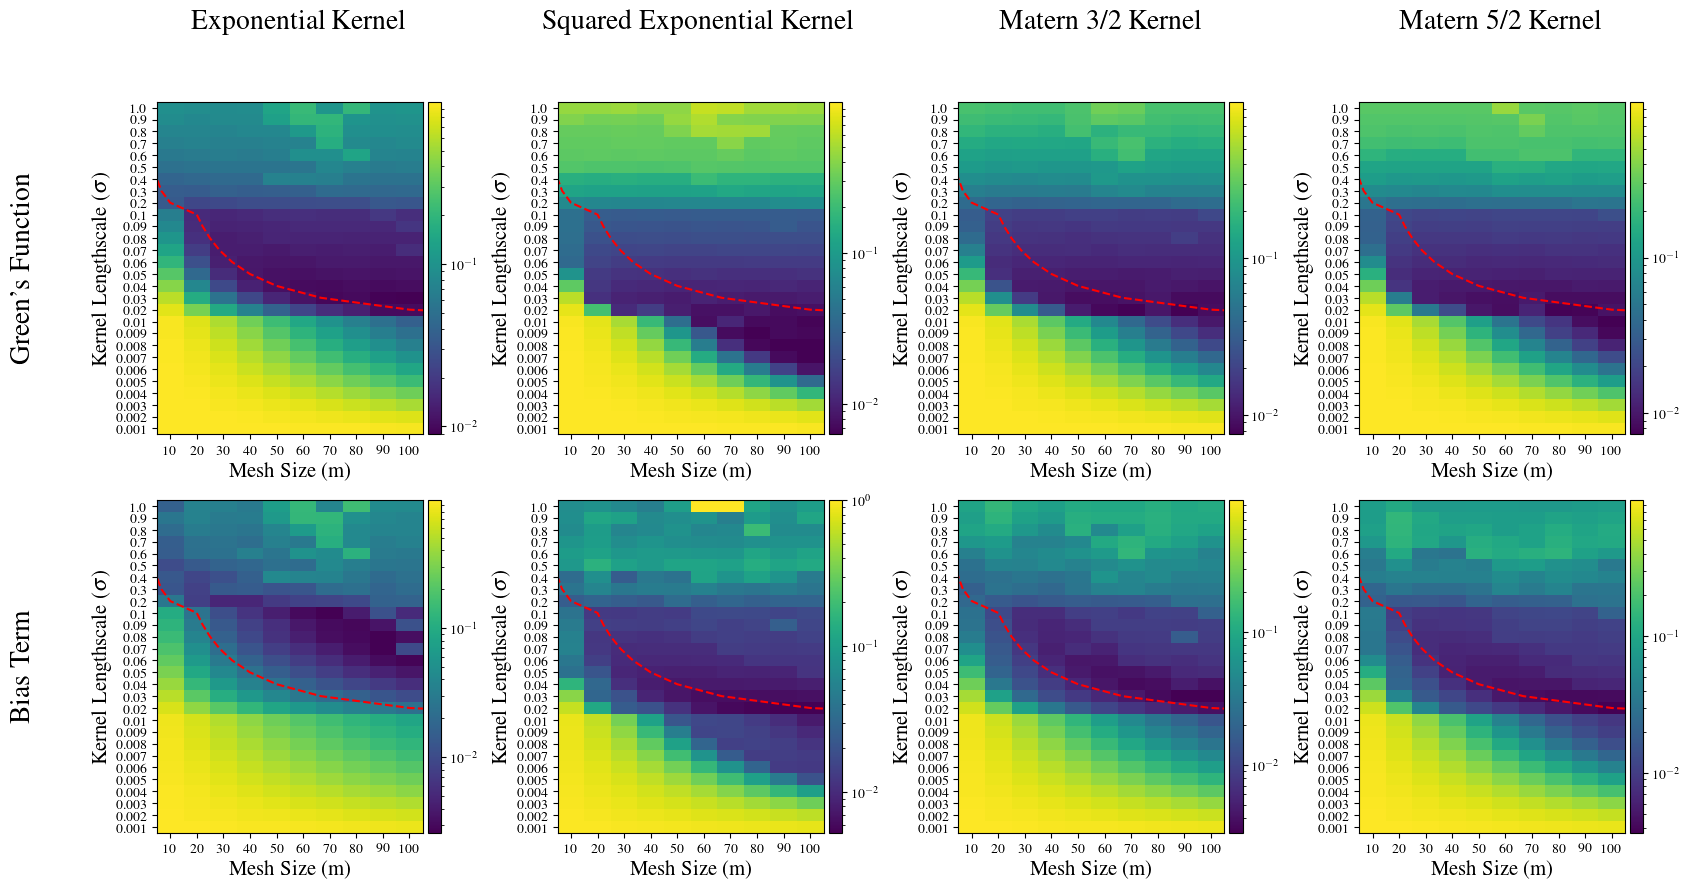

In [6]:
mx_weights = np.arange(10, 101, 10)
rkhs_kernel_widths = np.hstack([np.arange(1, 10) * 1e-3, np.arange(1, 10) * 1e-2, np.arange(1, 10) * 1e-1, 1])

fig, axs = plt.subplots(3, 5, figsize=(17, 9), gridspec_kw={'width_ratios':[0, 1, 1, 1, 1], 'height_ratios':[0, 1, 1]}, dpi=100)

axs[0, 0].remove()
axs[1, 0].set_ylabel("Green's Function", fontsize=20)
remove_spines(axs[1, 0])
axs[2, 0].set_ylabel("Bias Term", fontsize=20)
remove_spines(axs[2, 0])
axs[0, 1].set_title("Exponential Kernel", fontsize=20)
remove_spines(axs[0, 1])
axs[0, 2].set_title("Squared Exponential Kernel", fontsize=20)
remove_spines(axs[0, 2])
axs[0, 3].set_title("Matern 3/2 Kernel", fontsize=20)
remove_spines(axs[0, 3])
axs[0, 4].set_title("Matern 5/2 Kernel", fontsize=20)
remove_spines(axs[0, 4])

im = axs[1, 1].pcolormesh(G_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 1].set_xticklabels(mx_weights)
axs[1, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].set_xlim([0, len(mx_weights)])
axs[1, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 2].pcolormesh(G_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 2].set_xticklabels(mx_weights)
axs[1, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 2].set_xlim([0, len(mx_weights)])
axs[1, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 3].pcolormesh(G_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 3].set_xticklabels(mx_weights)
axs[1, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 3].set_xlim([0, len(mx_weights)])
axs[1, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 4].pcolormesh(G_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 4].set_xticklabels(mx_weights)
axs[1, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 4].set_xlim([0, len(mx_weights)])
axs[1, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 1].pcolormesh(beta_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 1].set_xticklabels(mx_weights)
axs[2, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 1].set_xlim([0, len(mx_weights)])
axs[2, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 2].pcolormesh(beta_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 2].set_xticklabels(mx_weights)
axs[2, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 2].set_xlim([0, len(mx_weights)])
axs[2, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 3].pcolormesh(beta_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 3].set_xticklabels(mx_weights)
axs[2, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 3].set_xlim([0, len(mx_weights)])
axs[2, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 4].pcolormesh(beta_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 4].set_xticklabels(mx_weights)
axs[2, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 4].set_xlim([0, len(mx_weights)])
axs[2, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

fig.tight_layout()
plt.savefig("../../figures/poisson_weight_hyperparams.png", bbox_inches="tight")
plt.show()

## Helmholtz Study of Kernel Size vs. Weight Discretization

In [7]:
sweeps = np.load("helmholtz_sweep.npz")
interp_res = sweeps["interp_res"][:, :, :, 0, :]
G_res = sweeps["G_res"][:, :, :, 0]
beta_res = sweeps["beta_res"][:, :, :, 0]
1 - np.mean(np.isnan(interp_res))

1.0

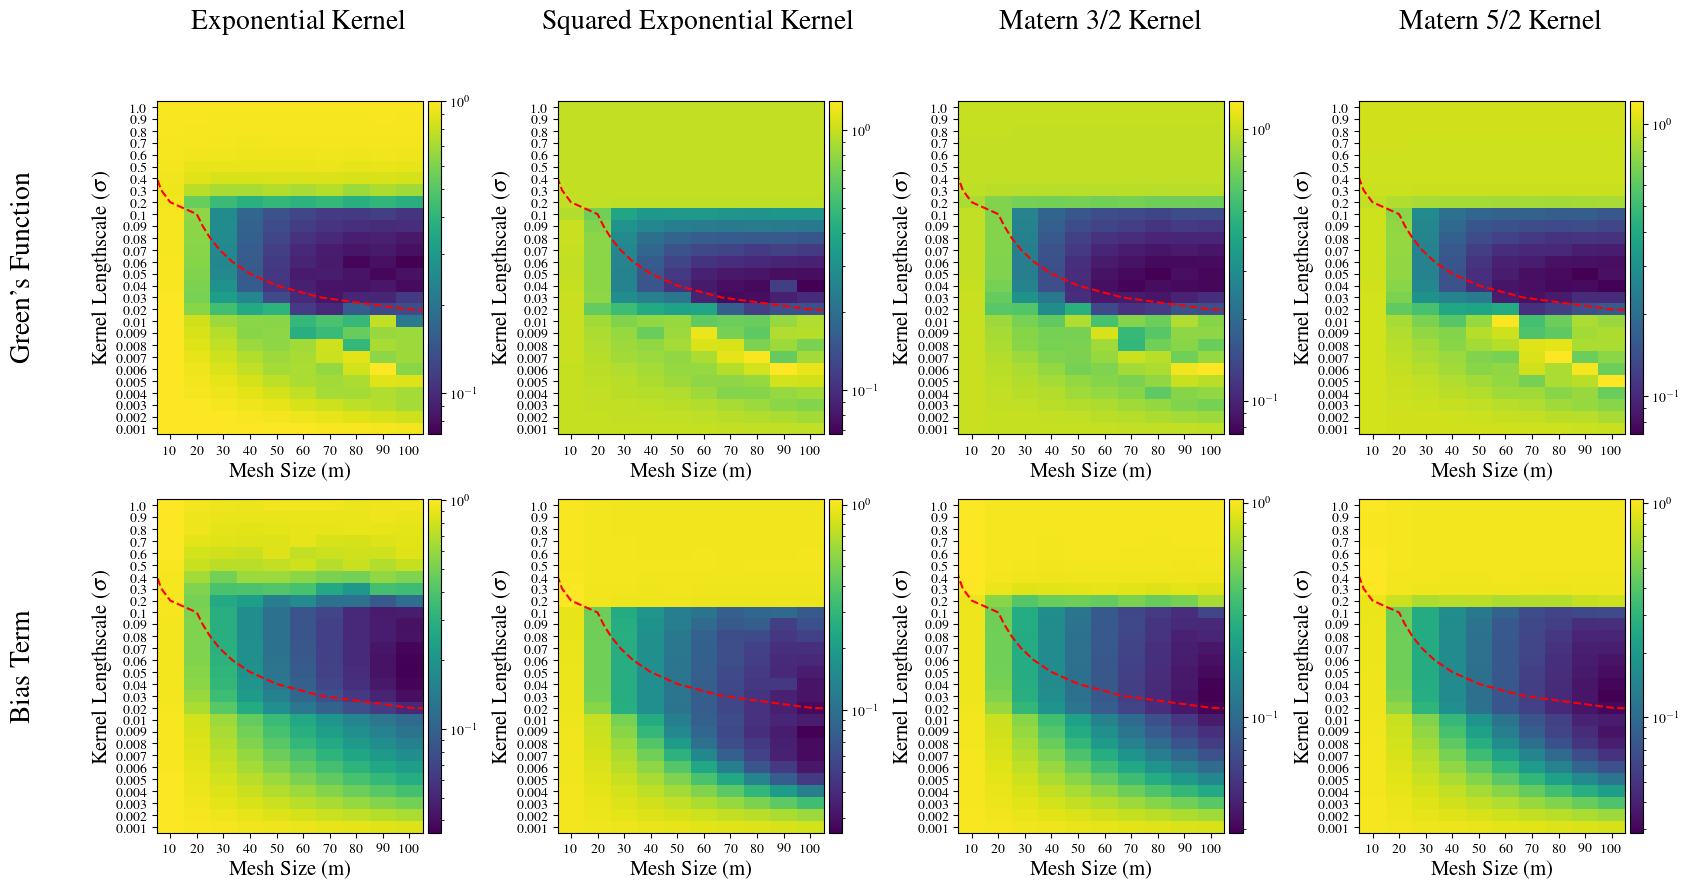

In [9]:
mx_weights = np.arange(10, 101, 10)
rkhs_kernel_widths = np.hstack([np.arange(1, 10) * 1e-3, np.arange(1, 10) * 1e-2, np.arange(1, 10) * 1e-1, 1])

fig, axs = plt.subplots(3, 5, figsize=(17, 9), gridspec_kw={'width_ratios':[0, 1, 1, 1, 1], 'height_ratios':[0, 1, 1]}, dpi=100)

axs[0, 0].remove()
axs[1, 0].set_ylabel("Green's Function", fontsize=20)
remove_spines(axs[1, 0])
axs[2, 0].set_ylabel("Bias Term", fontsize=20)
remove_spines(axs[2, 0])
axs[0, 1].set_title("Exponential Kernel", fontsize=20)
remove_spines(axs[0, 1])
axs[0, 2].set_title("Squared Exponential Kernel", fontsize=20)
remove_spines(axs[0, 2])
axs[0, 3].set_title("Matern 3/2 Kernel", fontsize=20)
remove_spines(axs[0, 3])
axs[0, 4].set_title("Matern 5/2 Kernel", fontsize=20)
remove_spines(axs[0, 4])

im = axs[1, 1].pcolormesh(G_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 1].set_xticklabels(mx_weights)
axs[1, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].set_xlim([0, len(mx_weights)])
axs[1, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 2].pcolormesh(G_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 2].set_xticklabels(mx_weights)
axs[1, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 2].set_xlim([0, len(mx_weights)])
axs[1, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 3].pcolormesh(G_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 3].set_xticklabels(mx_weights)
axs[1, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 3].set_xlim([0, len(mx_weights)])
axs[1, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 4].pcolormesh(G_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 4].set_xticklabels(mx_weights)
axs[1, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 4].set_xlim([0, len(mx_weights)])
axs[1, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 1].pcolormesh(beta_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 1].set_xticklabels(mx_weights)
axs[2, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 1].set_xlim([0, len(mx_weights)])
axs[2, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 2].pcolormesh(beta_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 2].set_xticklabels(mx_weights)
axs[2, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 2].set_xlim([0, len(mx_weights)])
axs[2, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 3].pcolormesh(beta_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 3].set_xticklabels(mx_weights)
axs[2, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 3].set_xlim([0, len(mx_weights)])
axs[2, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 4].pcolormesh(beta_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 4].set_xticklabels(mx_weights)
axs[2, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 4].set_xlim([0, len(mx_weights)])
axs[2, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

fig.tight_layout()
plt.savefig("../../figures/helmholtz_weight_hyperparams.png", bbox_inches="tight")
plt.show()

## Poisson Training with Different Kernels

In [13]:
###############################################################################
#   Generate Poisson PDE Forcings and Solutions
###############################################################################

mx_train = 100
kernel_width_train = 1e-4 #0.01

data = h5py.File("../../generate_data/poisson_gaussianKLE1D_dirbc.hdf5", "r")
x_train = data[f"mesh{mx_train}"].attrs["mesh"][0]

num_train = 500
fs_train = data[f"mesh{mx_train}"][f"kernelwidth{kernel_width_train}"]["forcings"][:num_train, :]
us_train_clean = data[f"mesh{mx_train}"][f"kernelwidth{kernel_width_train}"]["solutions"][:num_train, :]

x_train = torch.from_numpy(x_train).type(tensor)
fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

# add noise to solutions at a given SNR
sigma = 0.0
us_train = us_train_clean + sigma * torch.std(us_train_clean) * torch.randn(num_train, mx_train).type(tensor)

L = 1
left_dbc = -0.1
right_dbc = 0.1
w = 0

# whether bias term exists or not
bias = True

# true Green's kernel
mx_true = 1000
x_true = torch.linspace(0, L, mx_true).type(tensor)
X, Y = torch.meshgrid(x_true, x_true, indexing="ij")
G_true = torch.zeros((mx_true, mx_true)).type(tensor)
if np.abs(w) < 1e-15:
    G_true = (X + Y - torch.abs(Y - X)) / 2 - X * Y
else:
    modes = 100
    for k in range(1, modes):
        p = math.pi*k/L
        G_true += 2/L * torch.sin(p*X) * torch.sin(p*Y) / (p**2 - w**2)

beta_true = None
if bias:
    # true bias term
    beta_true = (right_dbc - left_dbc) * x_true + left_dbc
    if np.abs(w) >= 1e-15:
        A = (right_dbc - left_dbc * math.cos(w)) / math.sin(w)
        B = left_dbc
        beta_true = A*torch.sin(w*x_true) + B*torch.cos(w*x_true)

# compute the signal to noise of the solutions on the train data
snr = torch.sqrt(torch.mean(torch.sum(us_train**2, dim=0)) / torch.mean(torch.sum((us_train-us_train_clean)**2, dim=0)))
print('Signal to Noise Ratio: ' + str(snr))

Signal to Noise Ratio: tensor(inf, device='cuda:0')


In [ ]:
plt.figure(dpi=100)
plt.plot(x_train.cpu(), fs_train[0, :].cpu())
plt.xlabel("$x$", fontsize=16)
plt.title("Forcing $f(x)$", fontsize=20)
#plt.savefig("../../figures/poisson_forcing.png")
plt.show()

plt.figure(dpi=100)
plt.plot(x_train.cpu(), us_train[0, :].cpu(), color="red")
plt.plot(x_train.cpu(), us_train_clean[0, :].cpu(), linestyle="dashed", color="black")
plt.xlabel("$y$", fontsize=16)
plt.title("Solution $u(y)$ + $10\%$ noise", fontsize=20)
#plt.savefig("../../figures/poisson_solution.png")
plt.show()

In [14]:
mx_weight = 100
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)

epochs = 500
batch_size = 100

ind_divisor = 0
greens_out_meshes = (x_train, x_train)
greens_out_meshes_true = (x_true, x_true)
greens_weight_meshes = (x_weight, x_weight)

bias_out_meshes = (x_train,)
bias_out_meshes_true = (x_true,)
bias_weight_meshes = (x_weight,)

f_size = math.prod([len(x) for x in greens_out_meshes[:ind_divisor+1]])
f_size_true = math.prod([len(x) for x in greens_out_meshes_true[:ind_divisor+1]])
f_quadrature = trapezoid_rule(greens_out_meshes[:ind_divisor+1]).flatten()
u_size = math.prod([len(x) for x in greens_out_meshes[ind_divisor+1:]])
u_size_true = math.prod([len(x) for x in greens_out_meshes_true[ind_divisor+1:]])
u_quadrature = trapezoid_rule(greens_out_meshes[ind_divisor+1:]).flatten()

bias_lmbda = 1e-6
greens_lmbda = 1e-6

init_re_thresh = 1

rkhs_kernel_width = 2/mx_weight

greens_weight_parametrizations = [Symmetric((mx_weight, mx_weight), 0, 1, tri="both")]
def greens_transform_output(G, meshes):
    sizes = [len(x) for x in meshes]
    G = greens_weight_parametrizations[0](G, dims=sizes, tri="both") # symmetry constraint
    return G

"""
# Fit Green's function in tent RKHS
linear_greens_function, linear_bias_term, _, _, linear_rses, linear_G_rses, linear_beta_rses, linear_G_norms, linear_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Linear", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)
"""

# Fit Green's function in exponential RKHS
exp_greens_function, exp_bias_term, _, _, exp_rses, exp_G_rses, exp_beta_rses, exp_G_norms, exp_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Exponential", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in SE RKHS
se_greens_function, se_bias_term, _, _, se_rses, se_G_rses, se_beta_rses, se_G_norms, se_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "SquaredExponential", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in Matern 3/2 RKHS
m32_greens_function, m32_bias_term, _, _, m32_rses, m32_G_rses, m32_beta_rses, m32_G_norms, m32_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Matern3/2", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in Matern 5/2 RKHS
m52_greens_function, m52_bias_term, _, _, m52_rses, m52_G_rses, m52_beta_rses, m52_G_norms, m52_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Matern5/2", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

"""
# Fit Green's function in symmetric tent RKHS
linear_symm_greens_function, linear_symm_bias_term, _, _, linear_symm_rses, linear_symm_G_rses, linear_symm_beta_rses, linear_symm_G_norms, linear_symm_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Linear", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in symmetric exponential RKHS
exp_symm_greens_function, exp_symm_bias_term, _, _, exp_symm_rses, exp_symm_G_rses, exp_symm_beta_rses, exp_symm_G_norms, exp_symm_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Exponential", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in symmetric SE RKHS
se_symm_greens_function, se_symm_bias_term, _, _, se_symm_rses, se_symm_G_rses, se_symm_beta_rses, se_symm_G_norms, se_symm_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "SquaredExponential", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in symmetric Matern 3/2 RKHS
m32_symm_greens_function, m32_symm_bias_term, _, _, m32_symm_rses, m32_symm_G_rses, m32_symm_beta_rses, m32_symm_G_norms, m32_symm_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Matern3/2", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)

# Fit Green's function in symmetric Matern 5/2 RKHS
m52_symm_greens_function, m52_symm_bias_term, _, _, m52_symm_rses, m52_symm_G_rses, m52_symm_beta_rses, m52_symm_G_norms, m52_symm_beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, "Matern5/2", rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None, bias_learning_rate=None,
                   G_true=G_true, beta_true=beta_true,
                   init_re_thresh = init_re_thresh,
                   verbal=False)
"""

'\n# Fit Green\'s function in symmetric tent RKHS\nlinear_symm_greens_function, linear_symm_bias_term, _, _, linear_symm_rses, linear_symm_G_rses, linear_symm_beta_rses, linear_symm_G_norms, linear_symm_beta_norms =     train_rkhs_pde(fs_train, us_train, ind_divisor, "Linear", rkhs_kernel_width,\n                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, greens_lmbda=greens_lmbda,\n                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, bias_lmbda=bias_lmbda,\n                   batch_size=batch_size, epochs=epochs,\n                   greens_learning_rate=None, bias_learning_rate=None,\n                   G_true=G_true, beta_true=beta_true,\n                   greens_weight_parametrizations=greens_weight_parametrizations,\n                   greens_transform_output=greens_transform_output,\n                   init_re_thresh = init_re_thresh,\n                  

In [22]:
fig = plt.figure(figsize=(33, 15), dpi=500)
subfigs = fig.subfigures(3, 1, height_ratios=[1, 1, 1])
axsTop = subfigs[0].subplots(1, 5, gridspec_kw={'width_ratios':[0.1, 1, 1, 1, 0.1]})
axsMiddle = subfigs[1].subplots(1, 5)
axsBottom = subfigs[2].subplots(1, 5)

labels = ["Exponential", "Squared Exponential", "Matérn 3/2", "Matérn 5/2"]

axsTop[0].axis("off")
axsTop[4].axis("off")

axsTop[1].plot(exp_rses)
axsTop[1].plot(se_rses)
axsTop[1].plot(m32_rses)
axsTop[1].plot(m52_rses)
axsTop[1].set_xlabel("Epochs", fontsize=18)
axsTop[1].set_yscale("log")
axsTop[1].set_title("Train Relative Error vs. Epochs", fontsize=20)
axsTop[1].legend(labels, fontsize=18)

axsTop[2].plot(exp_G_rses)
axsTop[2].plot(se_G_rses)
axsTop[2].plot(m32_G_rses)
axsTop[2].plot(m52_G_rses)
axsTop[2].set_xlabel("Epochs", fontsize=18)
axsTop[2].set_yscale("log")
axsTop[2].set_title("Green's Function Relative Error vs. Epochs", fontsize=20)
axsTop[2].legend(labels, fontsize=18)

axsTop[3].plot(exp_beta_rses)
axsTop[3].plot(se_beta_rses)
axsTop[3].plot(m32_beta_rses)
axsTop[3].plot(m52_beta_rses)
axsTop[3].set_xlabel("Epochs", fontsize=18)
axsTop[3].set_yscale("log")
axsTop[3].set_title("Bias Term Relative Error vs. Epochs", fontsize=20)
axsTop[3].legend(labels, fontsize=18)

axsMiddle[0].pcolormesh(x_true.cpu().detach(), x_true.cpu().detach(), G_true.cpu().detach().T)
divider = make_axes_locatable(axsMiddle[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axsMiddle[0].set_xlabel("$x$", fontsize=18)
axsMiddle[0].set_ylabel("$y$", fontsize=18)
axsMiddle[0].set_xticks([0, 0.5, 1])
axsMiddle[0].set_yticks([0, 0.5, 1])
axsMiddle[0].set_title("True Green's Function", fontsize=20)
axsMiddle[0].set_aspect(1)

exp_greens_function.update_mesh(greens_out_meshes_true)
G = exp_greens_function().reshape(f_size_true, u_size_true)
axsMiddle[1].pcolormesh(x_true.cpu().detach(), x_true.cpu().detach(), (G-G_true).cpu().detach().T)
divider = make_axes_locatable(axsMiddle[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axsMiddle[1].set_xlabel("$x$", fontsize=18)
axsMiddle[1].set_ylabel("$y$", fontsize=18)
axsMiddle[1].set_xticks([0, 0.5, 1])
axsMiddle[1].set_yticks([0, 0.5, 1])
axsMiddle[1].set_title("Green's Function Absolute Difference\n in Exponential RKHS", fontsize=20)
axsMiddle[1].set_aspect(1)

se_greens_function.update_mesh(greens_out_meshes_true)
G = se_greens_function().reshape(f_size_true, u_size_true)
axsMiddle[2].pcolormesh(x_true.cpu().detach(), x_true.cpu().detach(), (G-G_true).cpu().detach().T)
divider = make_axes_locatable(axsMiddle[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axsMiddle[2].set_xlabel("$x$", fontsize=18)
axsMiddle[2].set_ylabel("$y$", fontsize=18)
axsMiddle[2].set_xticks([0, 0.5, 1])
axsMiddle[2].set_yticks([0, 0.5, 1])
axsMiddle[2].set_title("Green's Function Absolute Difference\n in Squared Exponential RKHS", fontsize=20)
axsMiddle[2].set_aspect(1)

m32_greens_function.update_mesh(greens_out_meshes_true)
G = m32_greens_function().reshape(f_size_true, u_size_true)
axsMiddle[3].pcolormesh(x_true.cpu().detach(), x_true.cpu().detach(), (G-G_true).cpu().detach().T)
divider = make_axes_locatable(axsMiddle[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axsMiddle[3].set_xlabel("$x$", fontsize=18)
axsMiddle[3].set_ylabel("$y$", fontsize=18)
axsMiddle[3].set_xticks([0, 0.5, 1])
axsMiddle[3].set_yticks([0, 0.5, 1])
axsMiddle[3].set_title("Green's Function Absolute Difference\n in Matérn 3/2 RKHS", fontsize=20)
axsMiddle[3].set_aspect(1)

m52_greens_function.update_mesh(greens_out_meshes_true)
G = m52_greens_function().reshape(f_size_true, u_size_true)
axsMiddle[4].pcolormesh(x_true.cpu().detach(), x_true.cpu().detach(), (G-G_true).cpu().detach().T)
divider = make_axes_locatable(axsMiddle[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axsMiddle[4].set_xlabel("$x$", fontsize=18)
axsMiddle[4].set_ylabel("$y$", fontsize=18)
axsMiddle[4].set_xticks([0, 0.5, 1])
axsMiddle[4].set_yticks([0, 0.5, 1])
axsMiddle[4].set_title("Green's Function Absolute Difference\n in Matérn 5/2 RKHS", fontsize=20)
axsMiddle[4].set_aspect(1)

axsBottom[0].plot(x_true.cpu().detach(), beta_true.cpu().detach())
axsBottom[0].set_xlabel("$y$", fontsize=18)
axsBottom[0].set_xticks([0, 0.5, 1])
axsBottom[0].set_title("True Bias Term", fontsize=20)

exp_bias_term.update_mesh(bias_out_meshes_true)
beta = exp_bias_term()
axsBottom[1].plot(x_true.cpu().detach(), torch.abs(beta-beta_true).cpu().detach())
axsBottom[1].set_xlabel("$y$", fontsize=18)
axsBottom[1].set_xticks([0, 0.5, 1])
axsBottom[1].set_title("Bias Term Absolute Difference\n in Exponential RKHS", fontsize=20)

se_bias_term.update_mesh(bias_out_meshes_true)
beta = se_bias_term()
axsBottom[2].plot(x_true.cpu().detach(), torch.abs(beta-beta_true).cpu().detach())
axsBottom[2].set_xlabel("$y$", fontsize=18)
axsBottom[2].set_xticks([0, 0.5, 1])
axsBottom[2].set_title("Bias Term Absolute Difference\n in Squared Exponential RKHS", fontsize=20)

m32_bias_term.update_mesh(bias_out_meshes_true)
beta = m32_bias_term()
axsBottom[3].plot(x_true.cpu().detach(), torch.abs(beta-beta_true).cpu().detach())
axsBottom[3].set_xlabel("$y$", fontsize=18)
axsBottom[3].set_xticks([0, 0.5, 1])
axsBottom[3].set_title("Bias Term Absolute Difference\n in Matérn 3/2 RKHS", fontsize=20)

m52_bias_term.update_mesh(bias_out_meshes_true)
beta = m52_bias_term()
axsBottom[4].plot(x_true.cpu().detach(), torch.abs(beta-beta_true).cpu().detach())
axsBottom[4].set_xlabel("$y$", fontsize=18)
axsBottom[4].set_xticks([0, 0.5, 1])
axsBottom[4].set_title("Bias Term Absolute Difference\n in Matérn 5/2 RKHS", fontsize=20)

plt.savefig("../../figures/poisson_kernels.png", bbox_inches="tight")
plt.show()

In [ ]:
import random


epochs = 1000
batch_size = 100

ind_divisor = 0
greens_out_meshes = (x_train, x_train)

kernels = ["Linear", "SquaredExponential", "Matern3/2", "Matern5/2"]
mx_weights = [500] #np.arange(50, 501, 50)
rkhs_kernel_widths = np.hstack([np.arange(1, 10) * 1e-3, np.arange(1, 10) * 1e-2, 1])
lambdas = [0.0] #[0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]

combinations = []
for i in range(len(kernels)):
    for j in range(len(mx_weights)):
        for k in range(len(rkhs_kernel_widths)):
            for l in range(len(lambdas)):
                combinations.append((i, j, k, l))
random.Random(10).shuffle(combinations)


mx_interps = np.arange(50, 1001, 50)

for combination in combinations:
    i, j, k, l = combination
    kernel = kernels[i]
    mx_weight = mx_weights[j]
    rkhs_kernel_width = rkhs_kernel_widths[k]
    lmbda = lambdas[l]
    
    print(f"Kernel: {kernel}", flush=True)
    print(f"Weight Mesh: {mx_weight}", flush=True)
    print(f"RKHS Kernel Width: {rkhs_kernel_width}", flush=True)
    print(f"Lambda: {lmbda}", flush=True)
    
    x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)
    greens_weight_meshes = (x_weight, x_weight)
    greens_function, bias_term, _, _, res, G_res, beta_res, G_norms, beta_norms = \
                train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, rkhs_kernel_width,
                               greens_out_meshes, greens_weight_meshes, greens_lmbda=0,
                               batch_size=batch_size, epochs=epochs,
                               greens_learning_rate=None,
                               verbal=True)
    
    for m in range(len(mx_interps)):
        mx_interp = mx_interps[m]
        x_interp = torch.linspace(x_train.min(), x_train.max(), mx_interp).type(tensor)

        greens_out_meshes_interp = (x_interp, x_interp)
        greens_out_sizes_interp = [len(x) for x in greens_out_meshes_interp]
        f_quadrature_interp = trapezoid_rule(greens_out_meshes_interp[:ind_divisor+1]).flatten()
        f_size_interp = math.prod([len(x) for x in greens_out_meshes_interp[:ind_divisor+1]])
        u_quadrature_interp = trapezoid_rule(greens_out_meshes_interp[ind_divisor+1:]).flatten()
        u_size_interp = math.prod([len(x) for x in greens_out_meshes_interp[ind_divisor+1:]])

        fs_train_interp = np.zeros((num_train, mx_interp))
        us_train_interp = np.zeros((num_train, mx_interp))
        for it in range(num_train):
            fs_train_interp[it, :] = np.interp(x_interp.detach().cpu().numpy(), x_train.detach().cpu().numpy(), fs_train[it, :].detach().cpu().numpy())
            us_train_interp[it, :] = np.interp(x_interp.detach().cpu().numpy(), x_train.detach().cpu().numpy(), us_train[it, :].detach().cpu().numpy())
        fs_train_interp = torch.from_numpy(fs_train_interp).type(tensor)
        us_train_interp = torch.from_numpy(us_train_interp).type(tensor)

        greens_function.update_mesh((greens_out_meshes_interp))
        G = greens_function()
        G = torch.reshape(G, (f_size_interp, u_size_interp))
        
        us_hat = (fs_train_interp * f_quadrature_interp) @ G
        #if bias_term is not None:
        #    bias_term.update_mesh((x_interp,))
        #    us_hat += bias_term()

        interp_re = relative_error(us_hat.cpu(), us_train_interp.cpu(), agg="mean").item()
        print(f"Combination ({i}, {j}, {k}, {l}, {m}): {interp_re}\n", flush=True)

Kernel: Matern3/2
Weight Mesh: 500
RKHS Kernel Width: 0.06
Lambda: 0.0


/home/gridsan/gstepaniants/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Green's Function Learning Rate: 100


In [ ]:
f_size = math.prod([len(x) for x in greens_out_meshes[:ind_divisor+1]])
f_size_true = math.prod([len(x) for x in greens_out_meshes_true[:ind_divisor+1]])
f_quadrature = trapezoid_rule(greens_out_meshes[:ind_divisor+1]).flatten()
u_size = math.prod([len(x) for x in greens_out_meshes[ind_divisor+1:]])
u_size_true = math.prod([len(x) for x in greens_out_meshes_true[ind_divisor+1:]])
u_quadrature = trapezoid_rule(greens_out_meshes[ind_divisor+1:]).flatten()

In [ ]:
plt.plot(np.log10(linear_rses))
plt.plot(np.log10(smooth_rses))
plt.show()

In [ ]:
# interpolate Green's function to fine mesh
G_linear = linear_greens_function()
G_linear = torch.reshape(G_linear, (f_size, u_size))
G_linear = nn.functional.interpolate(G_linear[None, None, :, :], size=(f_size_true, u_size_true))[0, 0, :, :]

# evaluate smooth RKHS Green's function on a fine mesh
smooth_greens_function.update_mesh(greens_out_meshes_true)
G_smooth = smooth_greens_function()
G_smooth = torch.reshape(G_smooth, (f_size_true, u_size_true))


# plot linearly interpolated Green's function
plt.figure(3)
fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=600)
axs[0].set_title('Matrix Estimator', fontsize=20, fontweight='bold')
im = axs[0].pcolormesh(x_true.cpu(), x_true.cpu(), G_linear.cpu().detach().T, shading='auto')
axs[0].set_xlabel('$x$', fontsize=18)
axs[0].set_ylabel('$y$', fontsize=18)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

# plot smooth RKHS Green's function
axs[1].set_title('Smooth RKHS Estimator', fontsize=20, fontweight='bold')
im = axs[1].pcolormesh(x_true.cpu(), x_true.cpu(), G_smooth.cpu().detach().T, shading='auto')
axs[1].set_xlabel('$x$', fontsize=18)
axs[1].set_ylabel('$y$', fontsize=18)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

# plot true Green's function
axs[2].set_title('True Green\'s Function', fontsize=20, fontweight='bold')
im = axs[2].pcolormesh(x_true.cpu(), x_true.cpu(), G_true.cpu().detach().T, shading='auto')
axs[2].set_xlabel('$x$', fontsize=18)
axs[2].set_ylabel('$y$', fontsize=18)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.savefig("../../figures/poisson_linear_interp.png")
plt.show()

In [ ]:
smooth_greens_function.update_mesh(greens_out_meshes)
G_smooth = smooth_greens_function()
G_smooth = torch.reshape(G_smooth, (f_size, u_size))

linear_greens_function.update_mesh(greens_out_meshes)
G_linear = linear_greens_function()
G_linear = torch.reshape(G_linear, (f_size, u_size))

plt.pcolormesh(x_train.cpu(), x_train.cpu(), G_linear.cpu().detach())
plt.show()


plt.pcolormesh(x_train.cpu(), x_train.cpu(), G_smooth.cpu().detach())
plt.show()


In [ ]:
smooth_greens_function.update_mesh(greens_out_meshes_true)
G_smooth = smooth_greens_function()
G_smooth = torch.reshape(G_smooth, (f_size_true, u_size_true))

linear_greens_function.update_mesh(greens_out_meshes_true)
G_linear = linear_greens_function()
G_linear = torch.reshape(G_linear, (f_size_true, u_size_true))

In [ ]:
G_interp = nn.functional.interpolate(G_linear[None, None, :, :], size=(500, 500))[0, 0, :, :]

plt.pcolormesh(x_true.cpu(), x_true.cpu(), G_interp.cpu().detach())
plt.colorbar()
plt.show()

plt.pcolormesh(x_true.cpu(), x_true.cpu(), G_linear.cpu().detach())
plt.colorbar()
plt.show()

plt.pcolormesh(x_true.cpu(), x_true.cpu(), torch.abs(G_linear.cpu().detach() - G_interp.cpu().detach()))
plt.colorbar()
plt.show()


In [ ]:
mx_weight = 100
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)

kernel = "Matern5/2" #"Linear"
sigma = 1/(mx_weight-1)

lmbda = 0 #1e-5

epochs = 1000
plotting_freq = 10
batch_size = 100
learning_rate = 1e-2

ind_divisor = 0
greens_out_meshes = (x_train, x_train)
greens_out_meshes_true = (x_true, x_true)
greens_weight_meshes = (x_weight, x_weight)

bias_out_meshes = None #(x_train,)
bias_out_meshes_true = None #(x_true,)
bias_weight_meshes = None #(x_weight,)

greens_weight_parametrizations = [Symmetric((mx_weight, mx_weight), 0, 1), FlipSymmetric((mx_weight, mx_weight), 0, 1)]
bias_weight_parametrizations = []

def greens_transform_output(G, meshes):
    sizes = [len(x) for x in meshes]
    G = greens_weight_parametrizations[0](G, dims=sizes, tri="both")
    G = greens_weight_parametrizations[1](G, dims=sizes, direction="both")
    return G

bias_transform_output = None

def plotting_function(us_train_hat):
    example_ind = 0
    u_train = us_train[example_ind, :].cpu()
    u_clean = us_train_clean[example_ind, :].cpu()
    u_hat = us_train_hat[example_ind, :].cpu()
    plt.figure(1)
    plt.title('Training Output Example', fontweight='bold')
    plt.plot(x_train.cpu(), u_train, label='$u$ train')
    plt.plot(x_train.cpu(), u_clean, label='$u$ clean', color="k")
    plt.plot(x_train.cpu(), u_hat.detach(), '--', label='$\widehat{u}$ pred')
    plt.xlabel('x')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
greens_function, bias_term, _, _, rses, G_rses, beta_rses, G_norms, beta_norms = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, sigma,
                   greens_out_meshes, greens_weight_meshes, greens_out_meshes_true=greens_out_meshes_true, G_true=G_true,
                   bias_out_meshes=bias_out_meshes, bias_weight_meshes=bias_weight_meshes, bias_out_meshes_true=bias_out_meshes_true, beta_true=beta_true,
                   greens_lmbda=lmbda, bias_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=learning_rate, bias_learning_rate=learning_rate,
                   greens_weight_parametrizations=greens_weight_parametrizations, bias_weight_parametrizations=bias_weight_parametrizations,
                   greens_transform_output=greens_transform_output, bias_transform_output=bias_transform_output,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)


In [ ]:
greens_function.parametrizations

In [ ]:
list(greens_function.named_parameters())

In [ ]:
greens_function.update_mesh(greens_out_meshes)
G = greens_function()
G = torch.reshape(G, (f_size, u_size))

plt.pcolormesh(G.cpu().detach())
plt.colorbar()
plt.show()

In [ ]:
# get rse for all examples in train set
G = greens_function()
G = torch.reshape(G, (f_size, u_size))
us_train_hat = (fs_train * f_quadrature) @ G
if bias:
    us_train_hat += beta
train_rses = relative_squared_error(us_train_hat.cpu(), us_train.cpu())

# interpolate Green's function and bias term to fine mesh
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function()
G = torch.reshape(G, (f_size_true, u_size_true))

if bias:
    bias_term.update_mesh(bias_out_meshes_true)
    beta = bias_term()

# plot relative squared errors over iterations
plt.figure(2)
plt.title('Relative Squared Errors', fontweight='bold')
plt.plot(range(len(rses)), rses, label='Train RSE', zorder=2)
plt.plot(range(len(G_rses)), G_rses, label='$\widehat{G}$ RSE', zorder=1)
if bias:
    plt.plot(range(len(beta_rses)), beta_rses, label='$\widehat{β}$ RSE', zorder=0)
plt.xlabel('Epochs')
plt.ylabel('Relative Train Error')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

# plot learned Green's function
vmin = torch.minimum(torch.min(G), torch.min(G_true)).item()
vmax = torch.maximum(torch.max(G), torch.max(G_true)).item()
plt.figure(3)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Predicted Green\'s Function $\widehat{G}(x, y)$', fontweight='bold')
axs[0].pcolormesh(x_true.cpu(), x_true.cpu(), G.cpu().detach(), shading='auto', vmin=vmin, vmax=vmax)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].set_title('True Green\'s Function $G(x, y)$', fontweight='bold')
im = axs[1].pcolormesh(x_true.cpu(), x_true.cpu(), G_true.cpu().detach(), shading='auto', vmin=vmin, vmax=vmax)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

cb_ax = fig.add_axes([1.0, 0.12, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(vmin, vmax, 10))
plt.tight_layout()
plt.show()

# plot learned bias term
if bias:
    plt.figure(4)
    plt.title('Predicted Bias Term $\widehat{β}(x)$' + ' (RSE: {:.3E})'.format(beta_rses[-1]), fontweight='bold')
    plt.plot(x_true.cpu(), beta_true.detach(), label='True $β$')
    plt.plot(x_true.cpu(), beta.cpu().detach(), '--', label='Predicted $\widehat{β}$')
    plt.xlabel('y')
    plt.legend(loc='upper right')
    plt.show()

# compute the relative train error on the solutions
train_rse = rses[-1]
print('Train Relative Squared Error: ' + str(train_rse))

# plot best and worst case train predictions
best_rse, best_ind = torch.min(train_rses, 0)
worst_rse, worst_ind = torch.max(train_rses, 0)

plt.figure(5)
plt.title('Best Train Prediction (RSE: {:.3E})'.format(best_rse), fontweight='bold')
plt.plot(x_train.cpu(), us_train_clean[best_ind, :].cpu())
plt.plot(x_train.cpu(), us_train_hat[best_ind, :].cpu().detach().numpy(), '--')
plt.xlabel('x')
plt.show()

plt.figure(6)
plt.title('Worst Train Prediction (RSE: {:.3E})'.format(worst_rse), fontweight='bold')
plt.plot(x_train.cpu(), us_train_clean[worst_ind, :].cpu())
plt.plot(x_train.cpu(), us_train_hat[worst_ind, :].cpu().detach().numpy(), '--')
plt.xlabel('x')
plt.show()

In [ ]:
###############################################################################
#   Test Functional Neural Network on New Mesh Sizes
###############################################################################

# number of test samples
num_test = 1000

kernel_width_sizes = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]
mesh_sizes = np.arange(100, 501, 50)

test_sigma = 0.0

test_mesh_rses = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
for i in range(len(mesh_sizes)):
    for j in range(len(kernel_width_sizes)):
        print(f'({i}, {j})')
        m = mesh_sizes[i]
        w = kernel_width_sizes[j]

        x_test = data[f"mesh{m}"].attrs["mesh"][0]
        mx_test = len(x_test)

        fs_test = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][:, -num_test:].T
        us_test_clean = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][:, -num_test:].T

        x_test = torch.from_numpy(x_test).type(tensor)
        fs_test = torch.from_numpy(fs_test)
        us_test_clean = torch.from_numpy(us_test_clean)

        # add noise to solutions at a given SNR
        us_test = us_test_clean + test_sigma * torch.std(us_test_clean) * torch.randn(num_test, mx_test)

        fs_test = fs_test.view(num_test, mx_test).type(tensor)
        us_test = us_test.view(num_test, mx_test).type(tensor)

        greens_function.update_mesh((x_test, x_test))
        G = greens_function()
        G = torch.reshape(G, (mx_test, mx_test))

        bias_term.update_mesh((x_test,))
        beta = bias_term()

        out_meshes = (x_test, x_test)
        f_quadrature = trapezoid_rule(out_meshes[:ind_divisor+1])
        us_test_hat = (fs_test * f_quadrature) @ G + beta
        test_rse = relative_squared_error(us_test_hat, us_test, agg="mean").item()
        test_mesh_rses[i, j] = test_rse

# plot test error of model on new test meshes
plt.figure(7)
plt.title('Relative Test Error (Trained on m = {})'.format(mx_train), y=1.05, fontweight='bold')
plt.pcolormesh(test_mesh_rses.T)
plt.xlabel('Mesh Size (m)')
plt.ylabel('Kernel Width ($\sigma$)')
plt.colorbar()
plt.show()


# plot learned Green's function
plt.figure(3)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Predicted Green\'s Function $\widehat{G}(x, y)$', fontweight='bold')
axs[0].pcolormesh(x_test.cpu(), x_test.cpu(), G.cpu().detach(), shading='auto')
#plt.colorbar()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].set_title('True Green\'s Function $G(x, y)$', fontweight='bold')
im = axs[1].pcolormesh(x_train.cpu(), x_train.cpu(), G_true.cpu().detach(), shading='auto')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

# plot best and worst case test predictions
test_rses = relative_squared_error(us_test_hat, us_test)
best_rse, best_ind = torch.min(test_rses, 0)
worst_rse, worst_ind = torch.max(test_rses, 0)

plt.figure(8)
plt.title('Best Test Prediction (RSE: {:.3E})'.format(best_rse), fontweight='bold')
plt.plot(x_test.cpu(), us_test[best_ind, :].cpu().detach())
plt.plot(x_test.cpu(), us_test_hat[best_ind, :].cpu().detach(), '--')
plt.xlabel('x')
plt.show()

plt.figure(9)
plt.title('Worst Test Prediction (RSE: {:.3E})'.format(worst_rse), fontweight='bold')
plt.plot(x_test.cpu(), us_test[worst_ind, :].cpu().detach())
plt.plot(x_test.cpu(), us_test_hat[worst_ind, :].cpu().detach(), '--')
plt.xlabel('x')
plt.show()

In [ ]:
plt.plot(test_mesh_rses)
plt.show()

In [ ]:
plt.plot(test_mesh_rses.T)
plt.show()